# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [56]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy

from scipy.stats import multinomial
from collections import Counter
from itertools import chain
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

In [3]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [4]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [5]:
X, y = read_dataset("hw1/spam")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [48]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.n_classes = len(self.classes)
        self.class_frequencies = counts / len(y)
        separated_classes = [X[y == cls] for cls in self.classes]
        self.word_frequences = [(x.sum(axis=0) + self.alpha) / (x.sum() + self.alpha * x.shape[1]) 
                                for x in separated_classes]
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        res = [[multinomial(x.sum(), self.word_frequences[cls]).logpmf(x) \
                + np.log(self.class_frequencies[cls]) for cls in range(self.n_classes)] for x in X]
        return np.array(res)
    

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [59]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        s = chain(*[x.split() for x in X])
        self.dict = {word[0]: idx for word, idx in zip(Counter(s).most_common(voc_limit), range(voc_limit))}
        self.n = len(self.dict)
        
    def transform(self, X):
        res = []
        for x in X:
            vec = np.zeros((self.n,))
            for word, count in Counter(x.split()).items():
                if word in self.dict:
                    vec[self.dict[word]] += count
            res.append(vec)
            
        return np.array(res)
        

In [60]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [61]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9836065573770492, 'spam': 0.9142857142857143},
 {'ham': 0.9876543209876543, 'spam': 0.8888888888888888},
 0.974910394265233)

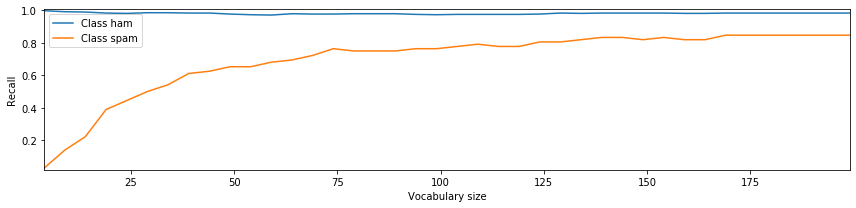

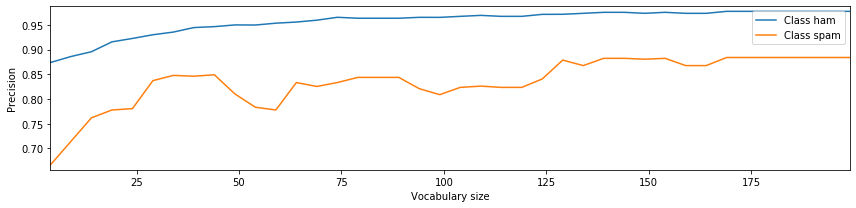

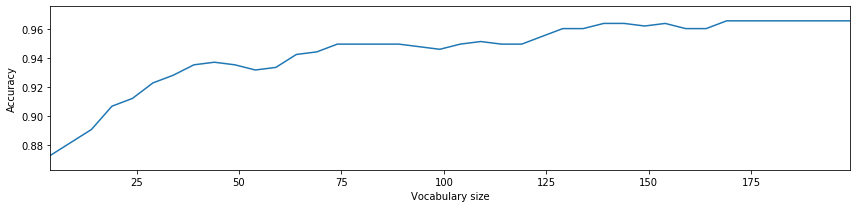

In [62]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [65]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.stemmer = SnowballStemmer('english')
        s = chain(*[x.split() for x in X])
        self.dict = {word[0]: idx for word, idx in zip(Counter(self.stemmer.stem(x) for x in s).most_common(voc_limit), range(voc_limit))}
        self.n = len(self.dict)
        
    def transform(self, X):
        res = []
        for sent in X:
            vec = np.zeros((self.n,))
            for word, count in Counter(self.stemmer.stem(x) for x in sent.split()).items():
                if word in self.dict:
                    vec[self.dict[word]] += count
            res.append(vec)
            
        return np.array(res)
        

In [66]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [67]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9856262833675564, 'spam': 0.9154929577464789},
 {'ham': 0.9876543209876543, 'spam': 0.9027777777777778},
 0.9767025089605734)

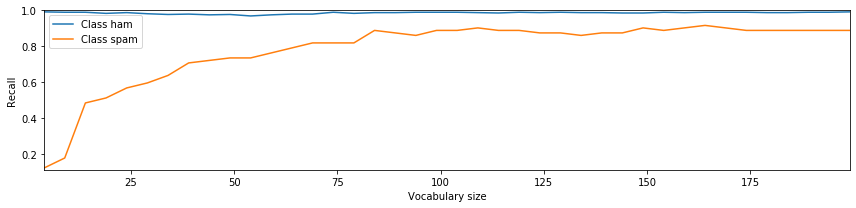

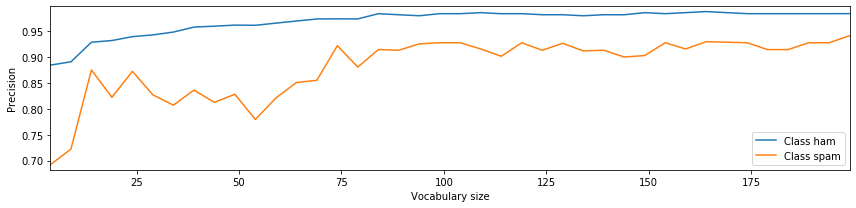

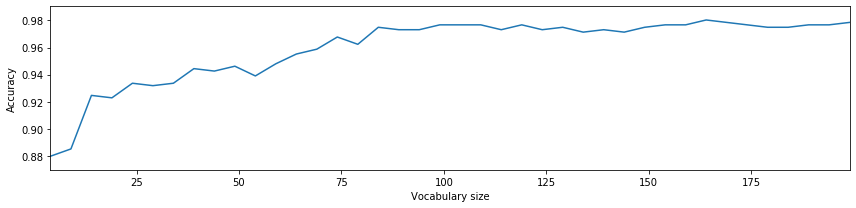

In [68]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)